## Loading and using a trained model for Dsprites
Notebook demonstrating how to load a JointVAE model and use it for various things.

In [1]:
from utils.load_model import load

path_to_model_folder = './trained_models/dsprites/'

model = load(path_to_model_folder)

In [2]:
# Print the latent distribution info
print(model.latent_spec)

{'disc': [3], 'cont': 10}


In [3]:
# Print model architecture
print(model)

VAE(
  (img_to_features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (features_to_hidden): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
  )
  (fc_mean): Linear(in_features=256, out_features=10, bias=True)
  (fc_log_var): Linear(in_features=256, out_features=10, bias=True)
  (fc_alphas): ModuleList(
    (0): Linear(in_features=256, out_features=3, bias=True)
  )
  (latent_to_features): Sequential(
    (0): Linear(in_features=13, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
  )
  (features_to_img): Sequential(
    (0): ConvTranspose2

In [4]:
from viz.visualize import Visualizer as Viz

# Create a Visualizer for the model
viz = Viz(model)
viz.save_images = False  # Return tensors instead of saving images

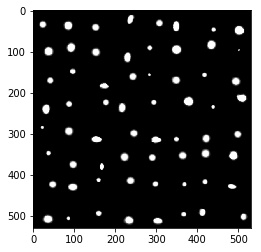

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

samples = viz.samples()
plt.imshow(samples.numpy()[0, :, :], cmap='gray')

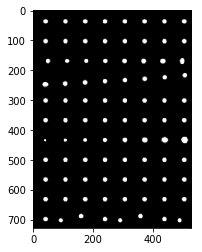

In [6]:
traversals = viz.all_latent_traversals()
plt.imshow(traversals.numpy()[0, :, :], cmap='gray')

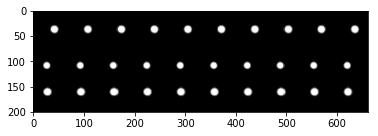

In [7]:
# Traverse 3rd continuous latent dimension across columns and first 
# discrete latent dimension across rows
traversals = viz.latent_traversal_grid(cont_idx=0, cont_axis=1, disc_idx=0, disc_axis=0, size=(3, 10))
plt.imshow(traversals.numpy()[0, :, :], cmap='gray')

#### Reorder discrete latent to match order of digits 

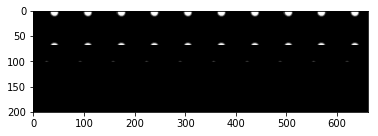

In [8]:
from viz.visualize import reorder_img

ordering = [1,0,2]  # The 9th dimension corresponds to 0, the 3rd to 1 etc...
traversals = reorder_img(traversals, ordering, by_row=True)
plt.imshow(traversals.numpy()[0, :, :], cmap='gray')

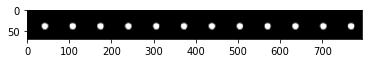

In [9]:
traversal = viz.latent_traversal_line(cont_idx=1, size=12)
plt.imshow(traversal.numpy()[0, :, :], cmap='gray')

In [10]:
from utils.dataloaders import get_dsprites_dataloader

# Get MNIST test data
dataloader = get_dsprites_dataloader(batch_size=32)

# Extract a batch of data
for batch, labels in dataloader:
    break
    
recon = viz.reconstructions(batch, size=(8, 8))

plt.imshow(recon.numpy()[0, :, :], cmap='gray')

FileNotFoundError: [Errno 2] No such file or directory: '../RF-VAE/data/dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'

### Encode data
The model can also be used to get encodings of the data

In [11]:
from torch.autograd import Variable
encodings = model.encode(Variable(batch))

NameError: name 'batch' is not defined

In [12]:
# Continuous encodings for the first 5 examples
encodings['cont'][0][:5]

NameError: name 'encodings' is not defined

In [13]:
from utils.dataloaders import get_dsprites_dataloader
subsample = 1000
import numpy as np
path_to_data = '../data/dsprites-data/dsprites_data.npz'
state = np.random.get_state()
data = np.load(path_to_data)
img = data['imgs']
np.random.shuffle(img)
imgs = img[::subsample]
label = data['latents_values'][:, 1]
np.random.set_state(state)
np.random.shuffle(label)
labels = label[:subsample]-1
# self.transform = transform
# Each image in the dataset has binary values so multiply by 255 to get
# pixel values


In [14]:
import torch
import torch
imgs = torch.tensor(imgs).float()
imgs = imgs.unsqueeze(1)
from torch.autograd import Variable
imgs = Variable(imgs)

In [15]:
import torch
latent_dist = model.encode(imgs)
_, predict_label = torch.max(latent_dist['disc'][0], dim=1)
confusion = torch.zeros(3, 3)
for i in range(738):
    confusion[int(labels[i]),predict_label[i].item()] += 1
for i in range(3):
    confusion[i] = confusion[i] / confusion[i].sum()

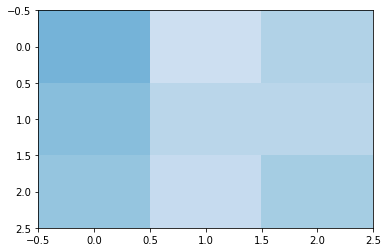

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
# confusion = np.array([[0.9,0.1,0.0],[0.0,0.8,0.2],[0.1,0.7,0.2]])
# confusion = torch.tensor(confusion)
from matplotlib import cm
plt.imshow(confusion,interpolation='nearest',cmap=cm.Blues,aspect='auto',vmin=0,vmax=1.0)

In [17]:
value, predict_label = torch.max(confusion, dim=1)

In [18]:
list_price_positoin_address = []
seen = []
for i in predict_label:
    if i in seen:
        pass
    else:
        seen.append(i)
        address_index = [x for x in range(len(predict_label)) if predict_label[x] == i]
        list_price_positoin_address.append([i, address_index])
dict_address = dict(list_price_positoin_address)
print(dict_address)

{tensor(0): [0, 1, 2]}


In [19]:
for keys in dict_address.keys():
    if(len(dict_address[keys])>1):
        acc = confusion[dict_address[keys],keys.item()]
        _, predict_label = torch.min(acc, dim=0)
        confusion[dict_address[keys][predict_label.item()],keys.item()] = 0.0
        value[dict_address[keys][predict_label.item()]], p = torch.max(confusion[dict_address[keys][predict_label.item()],:],dim=0)

In [20]:
value.mean()

tensor(0.4192)

In [22]:
from utils.load_model import load_param
spec,img_size = load_param(path_to_model_folder)

In [23]:
spec

{'cont_capacity': [0.0, 10.0, 300000, 150.0],
 'disc_capacity': [0.0, 15.0, 300000, 150.0],
 'record_loss_every': 1000,
 'batch_size': 64,
 'latent_spec': {'disc': [3], 'cont': 10},
 'epochs': [29, 30, 31],
 'experiment_name': '1',
 'lr': [0.0005],
 'print_loss_every': 1000,
 'dataset': 'dsprites'}